<a href="https://colab.research.google.com/github/TeneikaAskew/automating-web-scraping-text-calendar-notifications/blob/main/1_2_Texts_and_Calendar_Invites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Notebook: Calendar Events and Text Reminder

### Developer: Dakota Smith

This Python notebook replicates the functionality of a Google Apps Script for creating calendar events and sending reminder texts based on user input. The script interacts with a session data sheet, checks for relevant information such as user readiness, and sends calendar invites and text reminders.

### Purpose:
1. **Create Calendar Events**: Automatically generates calendar events based on data in the sessions sheet.
2. **Send Text Reminders**: Sends SMS or email reminders to users about upcoming sessions.
3. **Handle Missing Data**: Logs and skips rows with missing information.
4. **Manage Event Updates**: Marks events as "updated" once calendar invites and text messages are sent.

The script processes session data and sends notifications, which are logged for tracking.

In [ ]:
# @title
 %%javascript
function createCalendarEventsAndSendTexts() {
  // Access the active spreadsheet and relevant sheets
  const sessionsSheet = SpreadsheetApp.getActiveSpreadsheet().getSheetByName("Python_Sessions");
  const infoSheet = SpreadsheetApp.getActiveSpreadsheet().getSheetByName("Info");
  const calendar = CalendarApp.getDefaultCalendar(); // Access the user's default Google Calendar

  // Fetch all data from both sheets
  const sessionsData = sessionsSheet.getDataRange().getValues();
  const infoData = infoSheet.getDataRange().getValues();

  // Identify indices of key columns in the "Python_Sessions" sheet
  const dateIndex = sessionsData[0].indexOf("Date");
  const timeStartIndex = sessionsData[0].indexOf("Start Time");
  const timeEndIndex = sessionsData[0].indexOf("End Time");
  const titleIndex = sessionsData[0].indexOf("Title");
  const descriptionIndex = sessionsData[0].indexOf("Description");
  const locationIndex = sessionsData[0].indexOf("Location");
  const planningToGoIndex = sessionsData[0].indexOf("Planning to Go?");
  const readyToReceiveIndex = infoData[0].indexOf("Ready to Receive Invites and Texts?");

  // Fetch phone number from the "Info" sheet
  const phoneNumber = infoSheet.getRange("B3").getValue(); // Phone number is in cell B3
  console.log(phoneNumber); // Log the phone number to verify it's fetched correctly

  const textSentIndex = sessionsData[0].indexOf("Text Sent");
  const calInviteSentIndex = sessionsData[0].indexOf("Calendar Updated");

  // Add missing columns if they don't exist already
  let headerUpdated = false;

  if (textSentIndex === -1) {
    sessionsSheet.getRange(1, sessionsData[0].length + 1).setValue("Text Sent");
    textSentIndex = sessionsData[0].length; // Update index to point to the new column
    headerUpdated = true;
  }

  if (calInviteSentIndex === -1) {
    sessionsSheet.getRange(1, sessionsData[0].length + (headerUpdated ? 2 : 1)).setValue("Calendar Updated");
    calInviteSentIndex = sessionsData[0].length + (headerUpdated ? 1 : 0); // Update index to point to the new column
    headerUpdated = true;
  }

  // Refetch the data if headers were updated to reflect the new columns
  if (headerUpdated) {
    sessionsData = sessionsSheet.getDataRange().getValues();
  }

  // Check if any user is ready to receive invites or texts
  const readyUsers = infoData.some(row => row[readyToReceiveIndex] === "Yes" || row[readyToReceiveIndex] === "Text Only" || row[readyToReceiveIndex] === "Calendar Only");

  if (!readyUsers) {
    Logger.log("No users are ready to receive invites. Exiting script.");
    return;
  } else {
    Logger.log("Users are ready to receive invites. Continuing script.");
  }

  // Initialize a counter for how many sessions are processed
  let yesCount = 0;

  // Iterate over each session in the "Python_Sessions" sheet
  for (let i = 1; i < sessionsData.length; i++) {
    const row = sessionsData[i];
    const title = row[titleIndex];
    const date = row[dateIndex];
    const startTime = row[timeStartIndex];
    const endTime = row[timeEndIndex];
    const location = row[locationIndex];
    const description = row[descriptionIndex];

    // If user is planning to attend and calendar invite has not been sent yet
    if (row[planningToGoIndex] === "Yes" && row[calInviteSentIndex] !== "Yes") {
      yesCount++; // Increment the counter

      // Validate that all required fields are present
      let missingFields = [];
      if (!title) missingFields.push("Event Title");
      if (!date) missingFields.push("Date");
      if (!startTime) missingFields.push("Start Time");
      if (!endTime) missingFields.push("End Time");

      if (missingFields.length > 0) {
        Logger.log(`Skipping row ${i + 1} due to missing fields: ${missingFields.join(", ")}`);
        continue; // Skip the current iteration if required fields are missing
      }

      // Parse the start and end times
      const parsedDate = new Date(date);
      const [startHour, startMinute] = parseTime(startTime);
      const [endHour, endMinute] = parseTime(endTime);

      const startDate = new Date(parsedDate.getFullYear(), parsedDate.getMonth(), parsedDate.getDate(), startHour, startMinute);
      const endDate = new Date(parsedDate.getFullYear(), parsedDate.getMonth(), parsedDate.getDate(), endHour, endMinute);

      // Create the calendar event
      calendar.createEvent(title, startDate, endDate, {
        location: location,
        description: description,
      });

      // Mark the "Calendar Updated" column as "Yes" for the current session
      sessionsSheet.getRange(i + 1, calInviteSentIndex + 1).setValue("Yes");
      Logger.log(`Event created: ${title} on ${startDate}`);
    }

    // If user is planning to attend and text hasn't been sent yet
    if (row[planningToGoIndex] === "Yes" && row[textSentIndex] !== "Yes") {
      if (phoneNumber) {
        const message = `TG Summit: ${title} was added to your calendar. You'll receive a reminder 10 minutes before the session. Check your calendar for details!`;

        // Send the text reminder (via email to phone number)
        MailApp.sendEmail({
          to: phoneNumber,
          subject: "Event Reminder",
          body: message,
        });

        // Mark the "Text Sent" column as "Yes"
        sessionsSheet.getRange(i + 1, textSentIndex + 1).setValue("Yes");
        Logger.log(`Text sent to ${phoneNumber} for row ${i + 1}`);
      } else {
        Logger.log(`No phone number found for row ${i + 1}. Skipping text.`);
      }
    }
  }

  // Log the total number of reminders sent
  Logger.log(`Total event reminders created/sent: ${yesCount}`);
}

// Function to parse time strings like "1:45pm" into hour and minute
function parseTime(timeString) {
  const timeMatch = timeString.match(/(\d+):(\d+)([ap]m)/i);
  if (!timeMatch) throw new Error(`Invalid time format: ${timeString}`);

  let hour = parseInt(timeMatch[1], 10);
  const minute = parseInt(timeMatch[2], 10);
  const period = timeMatch[3].toLowerCase();

  if (period === "pm" && hour < 12) hour += 12; // Convert PM to 24-hour time
  if (period === "am" && hour === 12) hour = 0; // Handle midnight

  return [hour, minute];
}

## Function: `createCalendarEventsAndSendTexts()`

### Purpose:
The `createCalendarEventsAndSendTexts()` function is responsible for automating the process of creating calendar events and sending text or email reminders for users based on data from a Google Spreadsheet. Specifically, it does the following:
- Creates calendar events based on session details (e.g., title, date, time, location).
- Sends text reminders (via email to phone numbers) to users who have marked that they are attending specific sessions.
- Updates the spreadsheet to reflect that calendar invites and text reminders have been sent.

### Breakdown of the Function:






1. **Fetching Data:**
   - The function begins by accessing two sheets in the Google Spreadsheet:
     - **Python_Sessions**: Contains session details (e.g., date, start time, title, description).
     - **Info**: Contains user details (e.g., phone number and whether they are ready to receive invites/texts).
   - The `getDataRange().getValues()` method is used to fetch all the data from these sheets into arrays for further processing.


In [ ]:
%%javascript
// Access the active spreadsheet and relevant sheets
  const sessionsSheet = SpreadsheetApp.getActiveSpreadsheet().getSheetByName("Python_Sessions");
  const infoSheet = SpreadsheetApp.getActiveSpreadsheet().getSheetByName("Info");
  const calendar = CalendarApp.getDefaultCalendar(); // Access the user's default Google Calendar

  // Fetch all data from both sheets
  const sessionsData = sessionsSheet.getDataRange().getValues();
  const infoData = infoSheet.getDataRange().getValues();


2. **Finding Column Indices:**
   - The function finds the indices of relevant columns within the `sessionsData` array (from the `Python_Sessions` sheet), including columns for date, start time, end time, title, description, location, and others.
   - It also identifies the column index for "Ready to Receive Invites and Texts?" in the `infoData` array (from the `Info` sheet) to determine which users are ready to receive invites or reminders.


In [ ]:
%%javascript
// Identify indices of key columns in the "Python_Sessions" sheet
  const dateIndex = sessionsData[0].indexOf("Date");
  const timeStartIndex = sessionsData[0].indexOf("Start Time");
  const timeEndIndex = sessionsData[0].indexOf("End Time");
  const titleIndex = sessionsData[0].indexOf("Title");
  const descriptionIndex = sessionsData[0].indexOf("Description");
  const locationIndex = sessionsData[0].indexOf("Location");
  const planningToGoIndex = sessionsData[0].indexOf("Planning to Go?");
  const readyToReceiveIndex = infoData[0].indexOf("Ready to Receive Invites and Texts?");


3. **Phone Number Fetch:**
   - The function retrieves the phone number from cell `B3` in the `Info` sheet, which will be used to send text reminders if applicable.


In [ ]:
%%javascript
 // Fetch phone number from the "Info" sheet
  const phoneNumber = infoSheet.getRange("B3").getValue(); // Phone number is in cell B3
  console.log(phoneNumber); // Log the phone number to verify it's fetched correctly



4. **Column Checks and Additions:**
   - The function checks if certain columns ("Text Sent" and "Calendar Updated") exist in the `sessionsData` array. If they don't, it adds them to the sheet and updates the relevant indices.

In [ ]:
%%javascript
  const textSentIndex = sessionsData[0].indexOf("Text Sent");
  const calInviteSentIndex = sessionsData[0].indexOf("Calendar Updated");

  // Add missing columns if they don't exist already
  let headerUpdated = false;

  if (textSentIndex === -1) {
    sessionsSheet.getRange(1, sessionsData[0].length + 1).setValue("Text Sent");
    textSentIndex = sessionsData[0].length; // Update index to point to the new column
    headerUpdated = true;
  }

  if (calInviteSentIndex === -1) {
    sessionsSheet.getRange(1, sessionsData[0].length + (headerUpdated ? 2 : 1)).setValue("Calendar Updated");
    calInviteSentIndex = sessionsData[0].length + (headerUpdated ? 1 : 0); // Update index to point to the new column
    headerUpdated = true;
  }

  // Refetch the data if headers were updated to reflect the new columns
  if (headerUpdated) {
    sessionsData = sessionsSheet.getDataRange().getValues();
  }

5. **User Readiness Check:**
   - The function checks whether any users are marked as ready to receive invites or texts. If no users are ready, the function exits early. If users are ready, the script continues with processing.

In [ ]:
%%javascript
 // Check if any user is ready to receive invites or texts
  const readyUsers = infoData.some(row => row[readyToReceiveIndex] === "Yes" || row[readyToReceiveIndex] === "Text Only" || row[readyToReceiveIndex] === "Calendar Only");

  if (!readyUsers) {
    Logger.log("No users are ready to receive invites. Exiting script.");
    return;
  } else {
    Logger.log("Users are ready to receive invites. Continuing script.");
  }

6. **Processing Each Session:**
   - The function then loops through each row of session data (starting from the second row to skip the header).
   - For each session, it checks if the user is planning to attend (`"Planning to Go?"` column) and whether a calendar invite has already been sent.
   - If the user is attending and the calendar invite has not been sent:
     - The function validates that all required fields (e.g., title, date, start time, end time) are present. If any fields are missing, it logs an error and skips the session.
     - The start and end times are parsed from string format (e.g., "1:45pm") into `Date` objects using the `parseTime()` helper function.
     - A calendar event is created using the `CalendarApp.createEvent()` method, and the "Calendar Updated" column is marked as "Yes" to indicate that an invite has been sent.

In [ ]:
%%javascript
// Initialize a counter for how many sessions are processed
  let yesCount = 0;

  // Iterate over each session in the "Python_Sessions" sheet
  for (let i = 1; i < sessionsData.length; i++) {
    const row = sessionsData[i];
    const title = row[titleIndex];
    const date = row[dateIndex];
    const startTime = row[timeStartIndex];
    const endTime = row[timeEndIndex];
    const location = row[locationIndex];
    const description = row[descriptionIndex];

    // If user is planning to attend and calendar invite has not been sent yet
    if (row[planningToGoIndex] === "Yes" && row[calInviteSentIndex] !== "Yes") {
      yesCount++; // Increment the counter

      // Validate that all required fields are present
      let missingFields = [];
      if (!title) missingFields.push("Event Title");
      if (!date) missingFields.push("Date");
      if (!startTime) missingFields.push("Start Time");
      if (!endTime) missingFields.push("End Time");

      if (missingFields.length > 0) {
        Logger.log(`Skipping row ${i + 1} due to missing fields: ${missingFields.join(", ")}`);
        continue; // Skip the current iteration if required fields are missing
      }

      // Parse the start and end times
      const parsedDate = new Date(date);
      const [startHour, startMinute] = parseTime(startTime);
      const [endHour, endMinute] = parseTime(endTime);

      const startDate = new Date(parsedDate.getFullYear(), parsedDate.getMonth(), parsedDate.getDate(), startHour, startMinute);
      const endDate = new Date(parsedDate.getFullYear(), parsedDate.getMonth(), parsedDate.getDate(), endHour, endMinute);

      // Create the calendar event
      calendar.createEvent(title, startDate, endDate, {
        location: location,
        description: description,
      });

      // Mark the "Calendar Updated" column as "Yes" for the current session
      sessionsSheet.getRange(i + 1, calInviteSentIndex + 1).setValue("Yes");
      Logger.log(`Event created: ${title} on ${startDate}`);
    }


 7. **Sending Text Reminders:**
   - If the user is attending and a text reminder has not been sent, the function sends an email to the provided phone number (using `MailApp.sendEmail()`) with a reminder about the session. The "Text Sent" column is then updated to "Yes" to indicate that the reminder has been sent.

In [ ]:
%%javascript
// If user is planning to attend and text hasn't been sent yet
    if (row[planningToGoIndex] === "Yes" && row[textSentIndex] !== "Yes") {
      if (phoneNumber) {
        const message = `TG Summit: ${title} was added to your calendar. You'll receive a reminder 10 minutes before the session. Check your calendar for details!`;

        // Send the text reminder (via email to phone number)
        MailApp.sendEmail({
          to: phoneNumber,
          subject: "Event Reminder",
          body: message,
        });

        // Mark the "Text Sent" column as "Yes"
        sessionsSheet.getRange(i + 1, textSentIndex + 1).setValue("Yes");
        Logger.log(`Text sent to ${phoneNumber} for row ${i + 1}`);
      } else {
        Logger.log(`No phone number found for row ${i + 1}. Skipping text.`);
      }
    }
  }

8. **Logging:**
   - Throughout the function, `Logger.log()` is used to log useful information for debugging and tracking, such as the number of events created and reminders sent.

In [ ]:
%%javascript
// Log the total number of reminders sent
  Logger.log(`Total event reminders created/sent: ${yesCount}`);
}


### Example of Workflow:
- **Input:** A user in the `Info` sheet is marked as "Yes" under "Ready to Receive Invites and Texts?". A session in the `Python_Sessions` sheet has the "Planning to Go?" column set to "Yes", but the calendar invite and text reminder have not yet been sent.
- **Process:** The function creates a calendar event for the session and sends a reminder text/email to the user.
- **Output:** The session's "Calendar Updated" and "Text Sent" columns are updated, and the user receives a reminder.

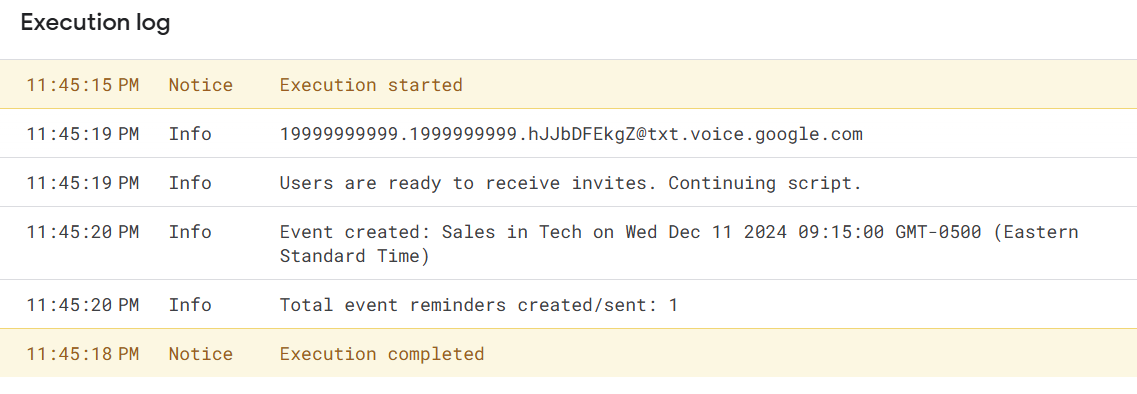

In [ ]:
%%javascript
// Function to parse time strings like "1:45pm" into hour and minute
function parseTime(timeString) {
  const timeMatch = timeString.match(/(\d+):(\d+)([ap]m)/i);
  if (!timeMatch) throw new Error(`Invalid time format: ${timeString}`);

  let hour = parseInt(timeMatch[1], 10);
  const minute = parseInt(timeMatch[2], 10);
  const period = timeMatch[3].toLowerCase();

  if (period === "pm" && hour < 12) hour += 12; // Convert PM to 24-hour time
  if (period === "am" && hour === 12) hour = 0; // Handle midnight


### Helper Function: `parseTime()`
- This helper function is used to convert a time string like `"1:45pm"` into a 24-hour time format that can be used for creating `Date` objects. It accounts for both AM/PM time formats and handles edge cases like midnight (`12:00am`).













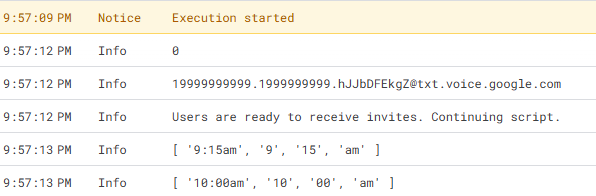